In this notebook,
- the simulation data is analysed alongside main detector data

In [18]:
# importing functions for analysis
from functions import *

%load_ext autoreload
%autoreload 2

# sometimes needs to be run twice to get good plots
%matplotlib inline
plt.rcParams['figure.dpi'] = 200

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Diffuse Reflection Probability

We assume that the tail of the main detection peak is the most sensitive parameter to the diffuse reflection probability of the materials. The goal is to generate simulations in which the timing constant, $\tau$, which defines this exponential decay can be matched to that of the experimental data.

## Experimental Data

The example below shows a fit of the experimental data

fit will begin at 25.6 s
fit will end at 35.6 s
[[Model]]
    Model(expo)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 279
    # data points      = 100
    # variables        = 2
    chi-square         = 150.005973
    reduced chi-square = 1.53067320
    Akaike info crit   = 44.5504931
    Bayesian info crit = 49.7608334
[[Variables]]
    p0:  18.5491355 +/- 0.06468245 (0.35%) (init = 80)
    p1:  2.42866096 +/- 0.01363245 (0.56%) (init = 30)
[[Correlations]] (unreported correlations are < 0.100)
    C(p0, p1) = -0.997



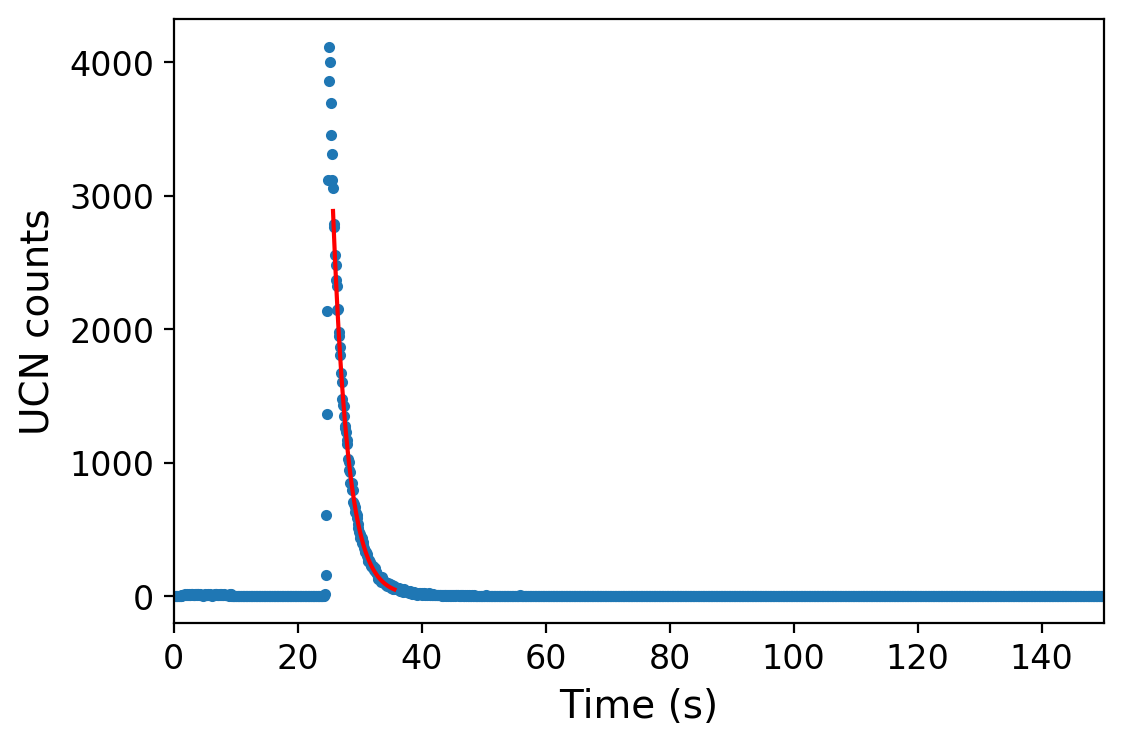

In [19]:
# load data from an example run 
filename = 'T081217_0034.tof'
arr = np.loadtxt("../data_ucn/main_detector/8/" + filename, usecols = (0,1));

# exponential function, same as ROOT's built-in 'expo'
def expo(x, p0, p1):
    return np.exp(p0 - 1/(p1) * x)

# times in seconds, specific to each run
irradiate_time = 8
fill_time = 8.6
pre_storage_time = 5
buffer_time = 4

# time length over which the fit will span
fit_span_time = 10

# compute the fit start and end times
fit_start_time = irradiate_time + fill_time + pre_storage_time + buffer_time
fit_end_time   = fit_start_time + fit_span_time

print('fit will begin at {} s'.format(fit_start_time))
print('fit will end at {} s'.format(fit_end_time))

# the experimental data is binned into 0.1s bins, and lmfit requires
# that we pass it the array we want fitted. We need to multiply these
# times to get the right indices for slicing the arrays
fit_start_index = int(fit_start_time * 10)
fit_end_index   = int(fit_end_time * 10)

# we get the arrays of counts and time, multiplying the values of t by 
# 0.1 to get it in seconds.
c = arr[fit_start_index:fit_end_index, 1]
t = arr[fit_start_index:fit_end_index,0] * 0.1

# construct weights, we deal with entries = 0 by giving them 0 weight
weights = np.zeros(np.shape(c))
for i in range(0,np.shape(c)[0]):
    if (c[i] != 0):
        weights[i] = 1 / np.sqrt(c[i])
    else:
        weights[i] = 0
        
gmodel = Model(expo)
result = gmodel.fit(c, x=t, p0=80, p1=30, weights = weights)

print(result.fit_report())
plt.plot(arr[:,0] * 0.1, arr[:,1], '.')
plt.plot(t, result.best_fit, 'r-')

plt.xlim([0,150])
# plt.yscale('log')
plt.ylabel('UCN counts', fontsize = 14)
plt.xlabel('Time (s)', fontsize = 14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.savefig('../img/rough_tail_fit.pdf')
plt.show()

Next, this is performed iteratively on the data from each run in the 85 mm and 72 mm normalization configurations.

(85mm_norm,005s): tau = 2.6392+/-0.0035, ave redchi = 1.9242320302886307
(85mm_norm,020s): tau = 2.804+/-0.004, ave redchi = 1.3689480675425476
(85mm_norm,100s): tau = 3.184+/-0.010, ave redchi = 0.9317114283662205
(72mm_norm,005s): tau = 2.874+/-0.011, ave redchi = 1.8455984131671508
(72mm_norm,020s): tau = 3.047+/-0.012, ave redchi = 1.1634410052095008
(72mm_norm,100s): tau = 3.363+/-0.029, ave redchi = 0.9536154174433256


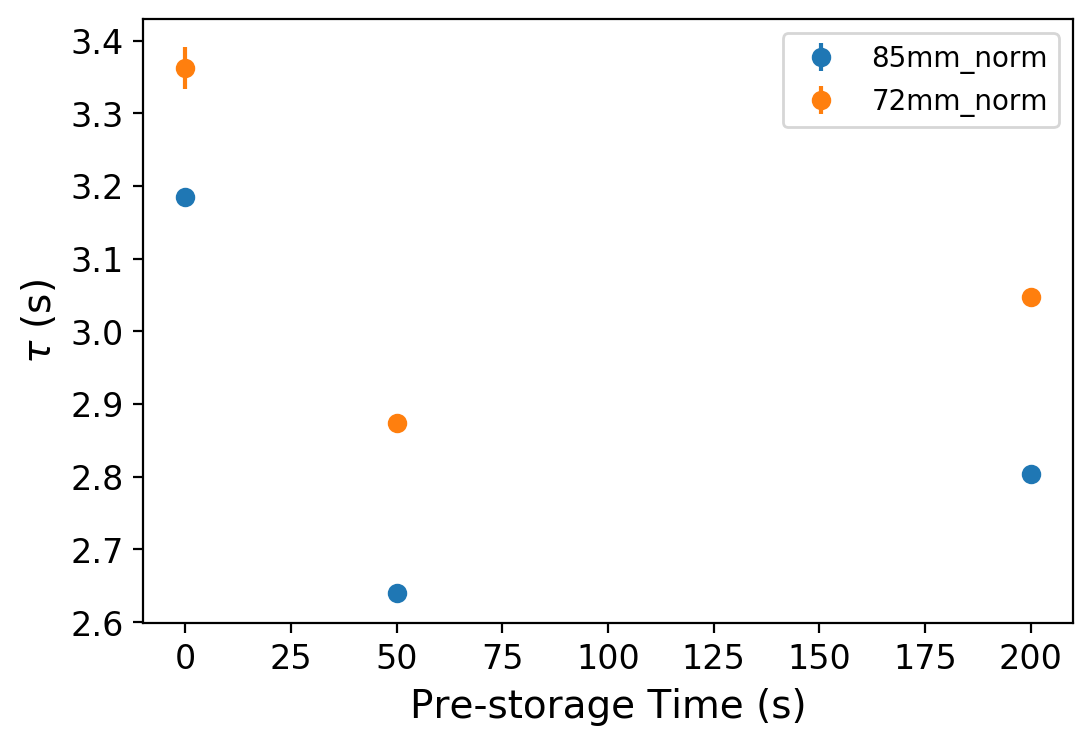

In [22]:
exp_p1_dict = fit_exp_detection_tail()

## Simulated Data

Using PENTrack, 20,000 particles are simulated in each simulation run. Simulations were only performed in the 85 mm normalization configuration. Below is a table showing the different simulation parameters for which simulations were performed. The root files are kept in the `data_sim` directory.

Filename (85mm_norm_{}.out.root)| Storage Time (s) | Lambert Ref. Prob. | Energy spectrum |   Configuration     |
---                             |     ---          |  ---               |  ---            |   ---               |
 020s_lp10_sqrt                 |      20          |  0.1               | $\sqrt{x}$      | 85 mm Normalization |
 100s_lp10_sqrt                 |     100          |  0.1               | $\sqrt{x}$      | 85 mm Normalization |
 100s_lp10_sqrt                 |       5          |  0.1               | $\sqrt{x}$      | 85 mm Normalization |
 020s_lp01_sqrt                 |      20          |  0.01              | $\sqrt{x}$      | 85 mm Normalization |
 100s_lp01_sqrt                 |     100          |  0.01              | $\sqrt{x}$      | 85 mm Normalization |
 100s_lp01_sqrt                 |       5          |  0.01              | $\sqrt{x}$      | 85 mm Normalization |
 020s_lp01_pow2                 |      20          |  0.01              | $x^2$           | 85 mm Normalization |
 100s_lp01_pow2                 |     100          |  0.01              | $x^2$           | 85 mm Normalization |
 100s_lp01_pow2                 |       5          |  0.01              | $x^2$           | 85 mm Normalization |
 020s_miro_sqrt                 |      20          |  none$^*$          | $\sqrt{x}$      | 85 mm Normalization |
 100s_miro_sqrt                 |     100          |  none              | $\sqrt{x}$      | 85 mm Normalization |
 100s_miro_sqrt                 |       5          |  none              | $\sqrt{x}$      | 85 mm Normalization |
 
$*$ - micro-roughness model used.

An example of the fitting with ROOT is shown, then all the various simulation data are fit iteratively.

Lambert Reflection Probability (LP) parameterizes the probability of the neutron being diffusely reflected upon collision with a surface. In simulations of the 85 mm normalization configuration, the value for LP given in the table is the value used for the plexi-glass guides, the pre-storage volume, and the source volume. 

 FCN=8.93016 FROM MIGRAD    STATUS=CONVERGED     520 CALLS         521 TOTAL
                     EDM=2.7239e-06    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           7.82703e+00   1.80271e-01   5.97079e-05  -1.73388e-02
   2  p1           9.30888e+00   4.72177e-01   1.55091e-04  -9.87753e-03
                               ERR DEF= 0.5


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: pdf file ../img/sim_fit_example.pdf has been created


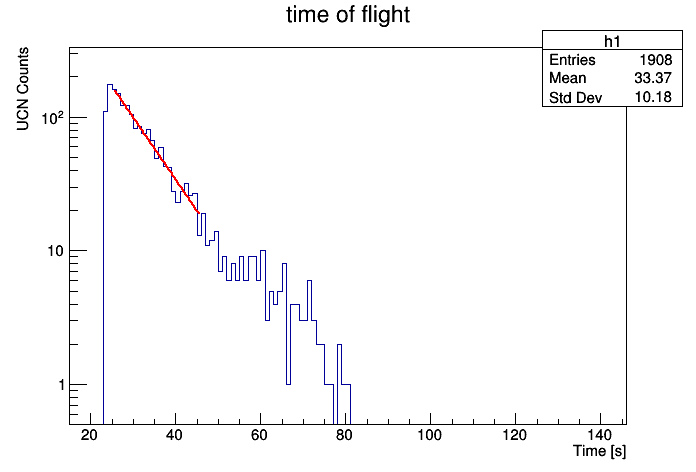

In [26]:
# open the appropriate file
filename = '../data_sim/85mm_norm_005s_lp01_sqrt_out.root'
f = ROOT.TFile.Open(filename)

# using rootpy to define the histogram
h1 = ROOT.TH1F("h1", "time of flight", 400, 0, 400)

# a canvas for plotting
canvas = ROOT.TCanvas("c1", "time of flight canvas", 700, 500)

# fill a histogram with only the neutrons ending in the detector
for evt in f.neutronend:
   if evt.solidend == 201: h1.Fill(evt.tend)

# logarithmic y scale 
canvas.SetLogy()

# draw histogram to the canvas
h1.Draw("hist")
canvas.Draw()

# fitting
# times relevant for fitting window selection
irradiate_time = 8
fill_time = 8.6
buffer_time = 4

# time length over which the fit will span
fit_span_time = 20

fit_start = irradiate_time + fill_time + 5 + buffer_time
fit_end   = fit_start + fit_span_time

f1 = ROOT.TF1("m1","exp([0]-1/[1]*x)", fit_start, fit_end)
f1.SetParameters(80,3)
fit = h1.Fit(f1, 'SRL')
redchi = fit.Chi2() / fit.Ndf()

# set the axis ranges for viewability
h1.GetXaxis().SetRangeUser(fit_start-10, fit_end + 100)

# get the slope, or inverse tau, parameter
slope = ufloat(f1.GetParameter(1), f1.GetParError(1))

h1.GetXaxis().SetTitle('Time [s]')
h1.GetYaxis().SetTitle('UCN Counts')
h1.Draw()
canvas.Draw()
canvas.Print('../img/sim_fit_example.pdf')

 FCN=8.93016 FROM MIGRAD    STATUS=CONVERGED     520 CALLS         521 TOTAL
                     EDM=2.7239e-06    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           7.82703e+00   1.80271e-01   5.97079e-05  -1.73388e-02
   2  p1           9.30888e+00   4.72177e-01   1.55091e-04  -9.87753e-03
                               ERR DEF= 0.5
 FCN=8.41413 FROM MIGRAD    STATUS=CONVERGED     567 CALLS         568 TOTAL
                     EDM=1.088e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           8.83602e+00   1.59965e-01   5.01346e-05  -1.24113e-02
   2  p1           7.71951e+00   2.93410e-01   9.19122e-05  -7.14142e-03
                               ERR DEF= 0.5
 FCN=15.7039 FROM MIG

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: pdf file ../img/tail_fit_85mm_norm_005s_lp01_sqrt.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: pdf file ../img/tail_fit_85mm_norm_005s_lp10_sqrt.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: pdf file ../img/tail_fit_85mm_norm_005s_miro_sqrt.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: pdf file ../img/tail_fit_85mm_norm_020s_lp01_sqrt.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: pdf file ../img/tail_fit_85mm_norm_020s_lp10_sqrt.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: pdf file ../img/tail_fit_85mm_norm_020s_miro_sqrt.pdf has been create

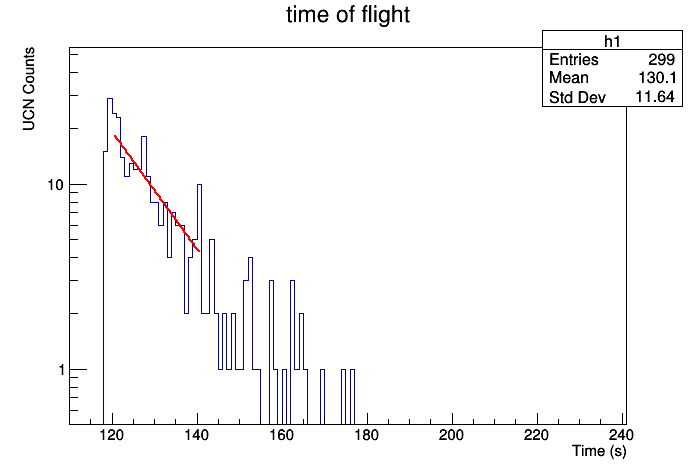

In [40]:
# iterative fitting

canvas_dict = {}
sim_p1_dict = {}

for run_type in ['005s', '020s', '100s']:

    for lp in ['lp01', 'lp10', 'miro']:

        # open the appropriate file
        filename = '../data_sim/85mm_norm_' + run_type + '_' + lp +'_sqrt_out.root'
        f = ROOT.TFile.Open(filename)

        # using rootpy to define the histogram
        h1 = ROOT.TH1F("h1", "time of flight", 400, 0, 400)

        # a canvas for plotting
        canvas = ROOT.TCanvas("c1", "time of flight canvas", 700, 500)

        # fill a histogram with only the neutrons ending in the detector
        for evt in f.neutronend:
           if evt.solidend == 201: h1.Fill(evt.tend)

        # logarithmic y scale 
        canvas.SetLogy()

        # draw histogram to the canvas
        h1.Draw("hist")
        canvas.Draw()

        # fitting
        # times relevant for fitting window selection
        irradiate_time = 8
        fill_time = 8.6
        buffer_time = 4

        # time length over which the fit will span
        fit_span_time = 20

        fit_start = irradiate_time + fill_time + int(run_type[0:3]) + buffer_time
        fit_end   = fit_start + fit_span_time

        f1 = ROOT.TF1("m1","exp([0]-1/[1]*x)", fit_start, fit_end)
        f1.SetParameters(80,3)
        fit = h1.Fit(f1, 'SRL')
        redchi = fit.Chi2() / fit.Ndf()

        # set the axis ranges for viewability
        h1.GetXaxis().SetRangeUser(fit_start-10, fit_end + 100)

        # get the slope, or inverse tau, parameter
        slope = ufloat(f1.GetParameter(1), f1.GetParError(1))

        h1.GetXaxis().SetTitle('Time (s)')
        h1.GetYaxis().SetTitle('UCN Counts')
        h1.Draw()
        canvas.Draw()
        canvas.Print('../img/tail_fit_' + filename[12:-9] + '.pdf')

        sim_p1_dict['85mm_norm',run_type,lp] = slope

        sim_p1_dict['85mm_norm',run_type,lp, 'redchi'] = redchi

Experimental Data (85mm_norm, 005s), average redchi = 1.9242320302886307
Simulated Data (85mm_norm, 005s, 10), redchi = 1.0582969410304905
Simulated Data (85mm_norm, 005s, 10), redchi = 0.9209616184171515
Simulated Data (85mm_norm, 005s, 10), redchi = 1.7695123876901657
Experimental Data (85mm_norm, 020s), average redchi = 1.3689480675425476
Simulated Data (85mm_norm, 020s, 10), redchi = 1.0470333444613906
Simulated Data (85mm_norm, 020s, 10), redchi = 1.3234462653024777
Simulated Data (85mm_norm, 020s, 10), redchi = 0.7778340901057761
Experimental Data (85mm_norm, 100s), average redchi = 0.9317114283662205
Simulated Data (85mm_norm, 100s, 10), redchi = 1.5951998206823035
Simulated Data (85mm_norm, 100s, 10), redchi = 0.6258638846748349
Simulated Data (85mm_norm, 100s, 10), redchi = 1.052474901909834


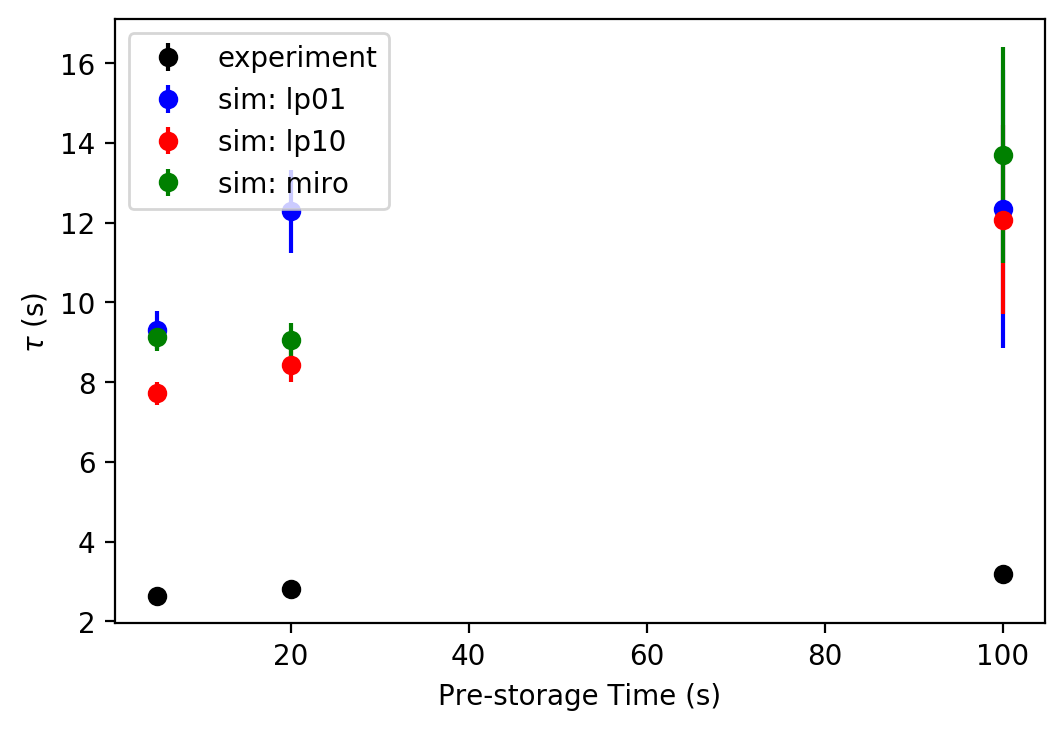

In [41]:
fig, ax = plt.subplots()
ax1 = plt.gca()

color_dict = {}
color_dict['lp01'] = 'b'
color_dict['lp10'] = 'r'
color_dict['miro'] = 'g'

for config in ['85mm_norm']:
    
    for run_type in ['005s', '020s', '100s']:
    
        exp_slope = exp_p1_dict[config, run_type]
        
        ax.errorbar(float(run_type[0:3]), exp_slope.nominal_value, yerr = exp_slope.std_dev,
                       label = 'experiment', fmt = 'o', color = 'k')
        
        print('Experimental Data (' + config + ', ' + run_type + '), average redchi = {}'.format(
        exp_p1_dict[config, run_type, 'redchi']))
        
        for lp in ['lp01', 'lp10', 'miro']:
    
#             if (config == 'NOMI' and run_type == 's005' and diffuse_probability == 10):
            
            slope = sim_p1_dict[config, run_type, lp]

            color = color_dict[lp]
            
            ax.errorbar(float(run_type[0:3]), slope.nominal_value, yerr = slope.std_dev,
                       label = 'sim: ' + lp, fmt = 'o', color = color)
            
            print('Simulated Data (' + config + ', ' + run_type + ', ' + 
                  str(diffuse_probability) + '), redchi = {}'.format(
            sim_p1_dict[config, run_type, lp, 'redchi']))
            
                
#             if (config == 'NOMI' and run_type == 's005' and diffuse_probability == 1):
            
#                 slope = sim_p1_dict[config, run_type, str(diffuse_probability)]
                
#                 color = next(ax1._get_lines.prop_cycler)['color']
                
#                 ax.errorbar(float(run_type[1:4]), slope.nominal_value, yerr = slope.std_dev,
#                            label = 'sim: dp = {}%'.format(diffuse_probability), fmt = 'o', color = color)
        
    
ax.set_ylabel(r'$\tau$ (s)')
ax.set_xlabel('Pre-storage Time (s)')
ax.legend();
handles, labels = ax.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys());

Here 'LP' stands for the Lambert Reflection Probability. 'lp01' is a LP value of 1%, and 'lp10' is an LP value of 10%. The label 'miro' denotes that these simulations were carried out under the microroughness model instead.

# Energy Spectrum in the Pre-Storage Volume

Using the neutron snapshots produced in the simulation, we'll look at how the energy spectrum evolves over time within the pre-storage volume. The 100 second pre-storage data will give the best view of this. 

Info in <TCanvas::Print>: pdf file ../img/spectrum_sqrt/snap1Eend.pdf has been created
Info in <TCanvas::Print>: pdf file ../img/spectrum_sqrt/snap2Eend.pdf has been created
Info in <TCanvas::Print>: pdf file ../img/spectrum_sqrt/snap3Eend.pdf has been created
Info in <TCanvas::Print>: pdf file ../img/spectrum_sqrt/snap4Eend.pdf has been created
Info in <TCanvas::Print>: pdf file ../img/spectrum_sqrt/snap5Eend.pdf has been created
Info in <TCanvas::Print>: pdf file ../img/spectrum_sqrt/snap6Eend.pdf has been created
Info in <TCanvas::Print>: pdf file ../img/spectrum_sqrt/snap7Eend.pdf has been created
Info in <TCanvas::Print>: pdf file ../img/spectrum_sqrt/snap8Eend.pdf has been created
Info in <TCanvas::Print>: pdf file ../img/spectrum_sqrt/snap9Eend.pdf has been created
Info in <TCanvas::Print>: pdf file ../img/spectrum_sqrt/snap10Eend.pdf has been created
Info in <TCanvas::Print>: pdf file ../img/spectrum_sqrt/snap11Eend.pdf has been created
Info in <TCanvas::Print>: pdf file ../img

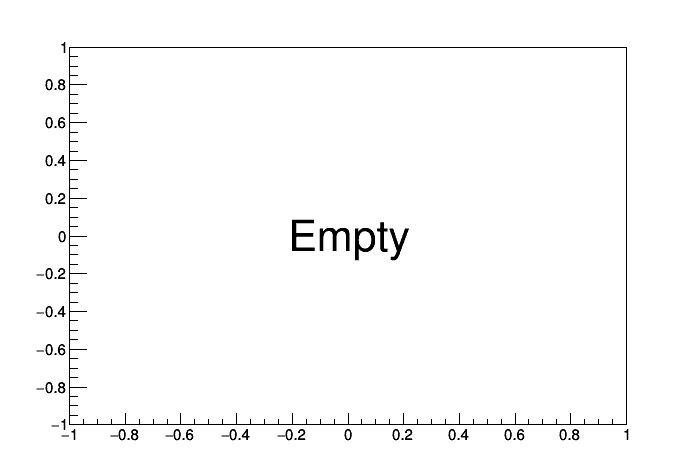

In [56]:
f = ROOT.TFile.Open('../data_sim/85mm_norm_100s_lp01_sqrt_out.root')

# iterate over the snapshot times.
for i in range(1,177):
    
    canvas = ROOT.TCanvas("c1_" + str(i), "canvas", 700, 500)
    f.neutronsnapshot.Draw("Eend", "tend == " + str(i))
    h1 = f.neutronsnapshot.GetHistogram()
    
    # drawing a vertical line for the mean
    mean = h1.GetMean()
    line = ROOT.TLine(mean, 0, mean, h1.GetMaximum());
    line.SetLineWidth(3)
    line.Draw()
    canvas.Draw()
    canvas.Print('../img/spectrum_sqrt/snap' + str(i) + 'Eend.pdf')

The below code block merges all the energy spectrum PDFs into a single PDF for easy scrolling through, to see how the spectrum changes over time.

In [74]:
from PyPDF2 import PdfFileMerger

pdfs = []
for i in range(1,177):
    if 'snap' + str(i) + 'Eend.pdf' in os.listdir('../img/spectrum_pow2/'):
        pdfs.append('../img/spectrum_pow2/snap' + str(i) + 'Eend.pdf')

merger = PdfFileMerger()

for pdf in pdfs:
    merger.append(pdf)

merger.write("../img/spectrum_sqrt/merged_E_spec_sqrt.pdf")
merger.close()

We make all the same PDFs, and the merged version, but for the simulations with an energy spectrum of $x^2$`

Info in <TCanvas::Print>: pdf file ../img/spectrum_pow2/snap1Eend.pdf has been created
Info in <TCanvas::Print>: pdf file ../img/spectrum_pow2/snap2Eend.pdf has been created
Info in <TCanvas::Print>: pdf file ../img/spectrum_pow2/snap3Eend.pdf has been created
Info in <TCanvas::Print>: pdf file ../img/spectrum_pow2/snap4Eend.pdf has been created
Info in <TCanvas::Print>: pdf file ../img/spectrum_pow2/snap5Eend.pdf has been created
Info in <TCanvas::Print>: pdf file ../img/spectrum_pow2/snap6Eend.pdf has been created
Info in <TCanvas::Print>: pdf file ../img/spectrum_pow2/snap7Eend.pdf has been created
Info in <TCanvas::Print>: pdf file ../img/spectrum_pow2/snap8Eend.pdf has been created
Info in <TCanvas::Print>: pdf file ../img/spectrum_pow2/snap9Eend.pdf has been created
Info in <TCanvas::Print>: pdf file ../img/spectrum_pow2/snap10Eend.pdf has been created
Info in <TCanvas::Print>: pdf file ../img/spectrum_pow2/snap11Eend.pdf has been created
Info in <TCanvas::Print>: pdf file ../img

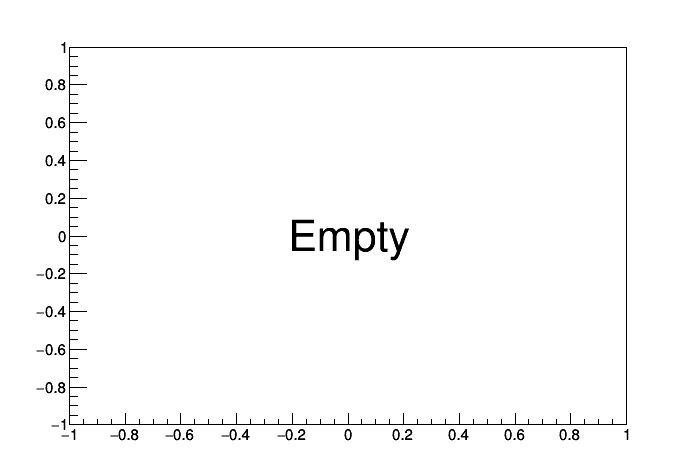

In [58]:
f = ROOT.TFile.Open('../data_sim/85mm_norm_100s_lp01_pow2_out.root')

# iterate over the snapshot times.
for i in range(1,177):
    
    canvas = ROOT.TCanvas("c1_" + str(i), "canvas", 700, 500)
    f.neutronsnapshot.Draw("Eend", "tend == " + str(i))
    h1 = f.neutronsnapshot.GetHistogram()
    
    # drawing a vertical line for the mean
    mean = h1.GetMean()
    line = ROOT.TLine(mean, 0, mean, h1.GetMaximum());
    line.SetLineWidth(3)
    line.Draw()
    canvas.Draw()
    canvas.Print('../img/spectrum_pow2/snap' + str(i) + 'Eend.pdf')

In [73]:
from PyPDF2 import PdfFileMerger

pdfs = []
for i in range(1,177):
    if 'snap' + str(i) + 'Eend.pdf' in os.listdir('../img/spectrum_pow2/'):
        pdfs.append('../img/spectrum_pow2/snap' + str(i) + 'Eend.pdf')

merger = PdfFileMerger()

for pdf in pdfs:
    merger.append(pdf)

merger.write("../img/spectrum_pow2/merged_E_spec_pow2.pdf")
merger.close()

In [72]:
pdfs

[]

# Energy of Neutrons as they are Absorbed in the Detector

We want to see what this histogram looks like for the different runs.

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: pdf file ../img/EndSpec_85mm_norm_005s_lp01_sqrt.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: pdf file ../img/EndSpec_85mm_norm_005s_lp10_sqrt.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: pdf file ../img/EndSpec_85mm_norm_005s_miro_sqrt.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: pdf file ../img/EndSpec_85mm_norm_020s_lp01_sqrt.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: pdf file ../img/EndSpec_85mm_norm_020s_lp10_sqrt.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: pdf file ../img/EndSpec_85mm_norm_020s_miro_sqrt.pdf has been created
Warn

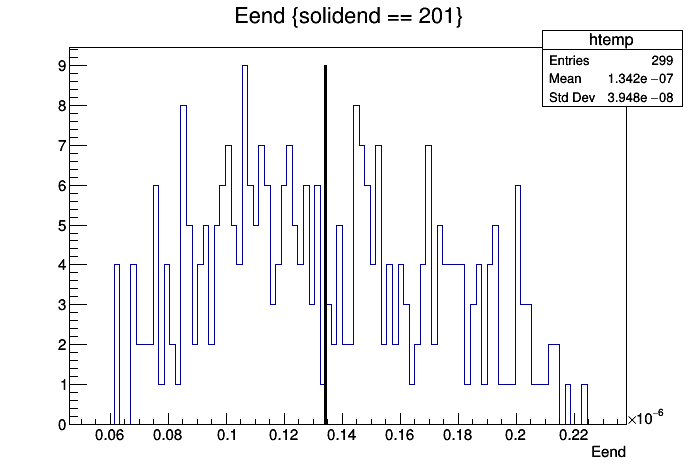

In [63]:
config = '85mm_norm'
    
for run_type in ['005s', '020s', '100s']:

    for lp in ['lp01', 'lp10', 'miro']:

        filename = '../data_sim/85mm_norm_' + run_type + '_' + lp +'_sqrt_out.root'
        f = ROOT.TFile.Open(filename)

        canvas = ROOT.TCanvas("c1", "canvas", 700, 500)
        f.neutronend.Draw("Eend", "solidend == 201")
        h1 = f.neutronend.GetHistogram()

        # drawing a vertical line for the mean
        mean = h1.GetMean()
        line = ROOT.TLine(mean, 0, mean, h1.GetMaximum());
        line.SetLineWidth(3)
        line.Draw()
        canvas.Draw()
        canvas.Print('../img/EndSpec_' + filename[12:-9] + '.pdf')